# Exercices
You have 4 exercises in this lab assignment. First two are about ensemble models. Third is about decision trees and the last one, about creating a random forest from individual decision trees.

*Credits:* Based on [code written by A. Géron](https://github.com/ageron/handson-ml2) for his book ""Hands-on ML with scikit-learn, keras and tensorflow.", 2nd edition 2019, O'Reilly Media. Code realeased under [Apache-2.0 License](https://github.com/ageron/handson-ml2/blob/master/LICENSE).

In [165]:
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from scipy import stats


## Voting Classifier on MNIST
### Data
This exercise uses the MNIST dataset: a set of 28x28 images containing hadnwritten 0-9 digits. It can be loaded using `sklern` functions as follows:

In [166]:
from sklearn.datasets import fetch_openml

# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

Here the feaures in X are simply all the 784 pixels of any given image, in vectorized form. To visualize the orignal image, the vector must be reshaped back to a 2D array as follows:

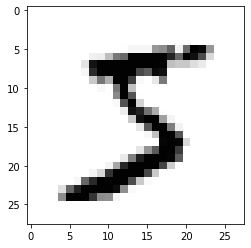

In [167]:
plt.imshow(X[0, :].reshape([28, 28]), cmap='Greys')

**The goal** is to correctly predict the digit from the image pixels. This is what you have in the y array:

In [168]:
y[0:10]

array(['5', '0', '4', '1', '9', '2', '1', '3', '1', '4'], dtype=object)

### Feture range and scaling
In general, that pixel values here range in 0-255. However, since digits are always cented, pixels in the center of the image tend to have a larger variance than those at the border. To visualize this, observe the plotting of the stddev for each pixel across all images. See how pixels at the border have near 0 variance while  those at the center have a much large one.

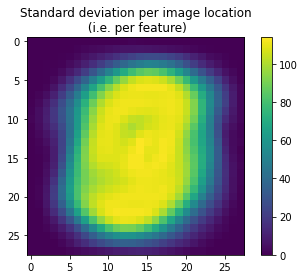

In [169]:
plt.imshow(X.std(axis=0).reshape([28,28]))
plt.colorbar()
plt.title("Standard deviation per image location\n (i.e. per feature)")
plt.show()

Remember models trained with continuous optimization (especially 1st order methods) benefit from features having a similar range (because this leads to better conditioned cost functions). For these methods **it is recommended that you apply some form of feature scaling**. For example, after applying standard scaling, variances become mostrly equal to 1, meaning all features lie in a similar range:

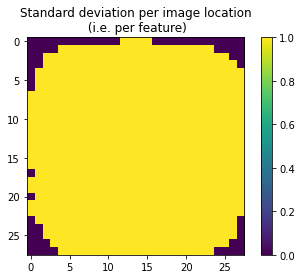

In [170]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)

plt.imshow(X_scaled.std(axis=0).reshape([28,28]))
plt.colorbar()
plt.title("Standard deviation per image location\n (i.e. per feature)")
plt.show()

### Exercise 
1. Load the MNIST data and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing). 

1. Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM classifier. 

1. Next, try to combine them into an ensemble that outperforms each individual classifier on the validation set, using soft or hard voting.

1. Once you have found one, try it on the test set. 
 
1. How much better does it perform compared to the individual classifiers?

In [171]:
y = y.reshape(-1,1).astype(None)

In [172]:
num_train = 50000
num_test = 10000
num_val = 10000
X_train, y_train = X[:num_train], y[:num_train]
X_val, y_val = X[num_train:num_train + num_val], y[num_train:num_train + num_val]
X_test, y_test = X[-num_test:], y[-num_test:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_val.shape, y_val.shape)

(50000, 784) (10000, 784) (50000, 1) (10000, 1) (10000, 784) (10000, 1)


In [173]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC

ext_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(random_state=42, max_iter=100)

ext_clf.fit(X_train, y_train)
rnd_clf.fit(X_train, y_train)
svm_clf.fit(X_train, y_train)

/tmp/ipykernel_3833265/47928124.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  ext_clf.fit(X_train, y_train)
/tmp/ipykernel_3833265/47928124.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rnd_clf.fit(X_train, y_train)
/home/fabrice/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fabrice/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=100, random_state=42)

In [174]:
ext_pred = ext_clf.predict(X_val)
rnd_pred = rnd_clf.predict(X_val)
svm_pred = svm_clf.predict(X_val)

In [175]:
from sklearn.metrics import accuracy_score
print(accuracy_score(ext_pred.reshape(-1,1), y_val))
print(accuracy_score(rnd_pred.reshape(-1,1), y_val))
print(accuracy_score(svm_pred.reshape(-1,1), y_val))

0.9743
0.9736
0.8685


In [176]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('lr', ext_clf), ('rf', rnd_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

/home/fabrice/.local/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fabrice/.local/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


VotingClassifier(estimators=[('lr', ExtraTreesClassifier(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft')

In [177]:
voting_pred = voting_clf.predict(X_val)
print(accuracy_score(voting_pred.reshape(-1,1), y_val))


0.9749


In [178]:
ext_pred = ext_clf.predict(X_test)
rnd_pred = rnd_clf.predict(X_test)
svm_pred = svm_clf.predict(X_test)
voting_pred = voting_clf.predict(X_test)

print(accuracy_score(voting_pred.reshape(-1,1), y_test))
print(accuracy_score(ext_pred.reshape(-1,1), y_test))
print(accuracy_score(rnd_pred.reshape(-1,1), y_test))
print(accuracy_score(svm_pred.reshape(-1,1), y_test))


0.9698
0.9703
0.968
0.8626


With Voting Classifier the accuracy is seemingly the same that for Extra Trees Classifier.

## Stacking Ensemble on MNIST
1. Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image’s class.
1. Train a classifier on this new training set. 
1. Congratulations, you have just trained a blender, and together with the classifiers it forms a stacking ensemble! 
1. Now evaluate the ensemble on the test set. 
1. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble’s predictions.
1. How does it compare to the voting classifier you trained earlier?

In [179]:
ext_pred = ext_clf.predict(X_val)
rnd_pred = rnd_clf.predict(X_val)
svm_pred = svm_clf.predict(X_val)

In [180]:
blender = np.concatenate((ext_pred.reshape(-1,1), svm_pred.reshape(-1,1), rnd_pred.reshape(-1,1), y_val), axis=1)
X_blender, y_blender = blender[:, :-1], blender[:, -1]
print(X_blender.shape, y_blender.shape)

(10000, 3) (10000,)


In [181]:
ext2_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
ext2_clf.fit(X_blender, y_blender)

ExtraTreesClassifier(random_state=42)

In [182]:
ext_pred = ext_clf.predict(X_test)
rnd_pred = rnd_clf.predict(X_test)
svm_pred = svm_clf.predict(X_test)

In [183]:
blender = np.concatenate((ext_pred.reshape(-1,1), svm_pred.reshape(-1,1), rnd_pred.reshape(-1,1), y_test), axis=1)
X_blender, y_blender = blender[:, :-1], blender[:, -1]
print(X_blender.shape, y_blender.shape)

(10000, 3) (10000,)


In [184]:
pred = ext2_clf.predict(X_blender)

In [186]:
print(accuracy_score(pred.reshape(-1,1), y_test))

0.9678


Stacking ensemble is slighter worst that Voting Classifier with the Extra Trees Classifier, but it's faster to compute.

## (Optional) Train and fine-tune a decision tree
Train and fine-tune a Decision Tree for the moons dataset by following these steps:  
  1. Use `make_moons(n_samples=10000, noise=0.4)` to generate a moons dataset.   
  1. Use `train_test_split()` to split the dataset into a training set and a test set.
  1. Use grid search with cross-validation (with the help of the `GridSearchCV` class) to find good hyperparameter values for a `DecisionTreeClassifier`. Hint: try various values for `max_leaf_nodes`.
  1. Train it on the full training set using these hyperparameters, and measure your model's performance on the test set. You should get roughly 85% to 87% accuracy.

In [289]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples = 10000, noise = 0.4, random_state=42)

In [290]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 2) (2000, 2) (8000,) (2000,)


In [291]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

parameters = {
    'min_samples_split': [20, 25, 30],
    'min_samples_leaf': [5, 8, 10],
    'max_leaf_nodes': [18, 19],
    'max_features': [2]
}

clf = GridSearchCV(DecisionTreeClassifier(random_state=42), parameters)

clf.fit(X_train, y_train)

clf_pred = clf.predict(X_test)
print(clf.best_estimator_)


DecisionTreeClassifier(max_features=2, max_leaf_nodes=19, min_samples_leaf=5,
                       min_samples_split=20, random_state=42)


In [292]:
y_pred_train = clf.predict(X_train)
print("Accuracy on training set: {:.2f}%".format(accuracy_score(y_train, y_pred_train) * 100))
y_pred_test = clf.predict(X_test)
print("Accuracy on test set: {:.2f}%".format(accuracy_score(y_test, y_pred_test) * 100))

Accuracy on training set: 86.39%
Accuracy on test set: 87.00%


## (Optional) Grow your own random forest
Grow a forest by following these steps:  
  
  1. Continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly. *Hint*: you can use ScikitLearn’s `ShuffleSplit` class for this.  
  1. Train one Decision Tree on each subset, using the best hyperparameter values found in the previous exercise. Evaluate these 1,000 Decision Trees on the test set. Since they were trained on smaller sets, these Decision Trees will likely perform worse than the first Decision Tree, achieving only about 80% accuracy.  
  1. Now comes the magic. For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy’s `mode()` function for this). This approach gives you majority-vote predictions over the test set.  
  1. Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5 to 1.5% higher).   
  1. Congratulations, you have trained a Random Forest classifier!

In [293]:
from sklearn.model_selection import ShuffleSplit
rs = ShuffleSplit(n_splits=1000, train_size=0.0125, random_state=42)

X_subsets = dict()
y_subsets = dict()
for i, indexes in enumerate(rs.split(X_train)):
    X_subsets[i] = X_train[indexes[0], :]
    y_subsets[i] = y_train[indexes[0]]



In [276]:
clf = DecisionTreeClassifier(max_features=2, max_leaf_nodes=19, min_samples_leaf=5,
                             min_samples_split=20, random_state=42)

DecisionTreeClassifier(max_leaf_nodes=22, random_state=30)


In [294]:
scores = []
for subset in range(0, 1000):
    #fit model
    clf.fit(X_subsets[subset], y_subsets[subset])
    # make predictions
    y_pred = clf.predict(X_test)
    # evaluate accuracy and store
    scores.append(accuracy_score(y_test, y_pred))

In [296]:
from scipy import stats

y_pred = []
for instance in range(0, X_test.shape[0]):
    predictions = []
    # loop through all the subsets
    for subset in range(0, 1000):
        # build a decision tree
        clf.fit(X_subsets[subset], y_subsets[subset])
        # make prediction for the instance in the test set and append to list
        predictions.append(clf.predict(X_test[instance].reshape(-1, 2)))
    # choose most voted class
    y_pred.append(stats.mode(np.array(predictions), axis=None)[0][0])

# evaluate performance using accuracy
print("Accuracy on test set: ", accuracy_score(y_test, y_pred))

/tmp/ipykernel_3833265/1568398161.py:15: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  y_pred.append(stats.mode(np.array(predictions), axis=None)[0][0])
/tmp/ipykernel_3833265/1568398161.py:15: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  y_pred.append(stats.mode